In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from torch_geometric.transforms import NormalizeFeatures
from nn import GCN

In [8]:
# create the adjaceny matrix from the edge index
def create_adj(edge_index, num_nodes):
    # edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    adj = np.zeros((num_nodes, num_nodes), dtype=int)
    for i, j in edge_index:
        adj[i-1, j-1] = 1
        adj[j-1, i-1] = 1
    
    adj = torch.tensor(adj, dtype=torch.float) + torch.eye(num_nodes)
    return adj

data = np.loadtxt("ucidata-zachary/out.ucidata-zachary", dtype=int, skiprows=2)

num_nodes = 34
features_dim = 2
adj = create_adj(data, num_nodes)

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
labels = [0 if i in labels else 1 for i in range(num_nodes)]
labels = torch.tensor(labels, dtype=torch.long)

In [9]:
# model and optimizer
model = GCN(nin=features_dim, nout=16, nhid=16, nclass=2, num_nodes=num_nodes)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
# train the model
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    output = model(adj)           # n x 2
    loss = F.cross_entropy(output, labels)  # for each node, cross entropy loss compares the probability of the labels to the true label
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.7009629607200623
Epoch: 10, Loss: 0.5664153099060059
Epoch: 20, Loss: 0.2707309424877167
Epoch: 30, Loss: 0.11475180834531784
Epoch: 40, Loss: 0.029094163328409195
Epoch: 50, Loss: 0.01322484202682972
Epoch: 60, Loss: 0.007108309771865606
Epoch: 70, Loss: 0.0040496052242815495
Epoch: 80, Loss: 0.002545183291658759
Epoch: 90, Loss: 0.0017690618988126516


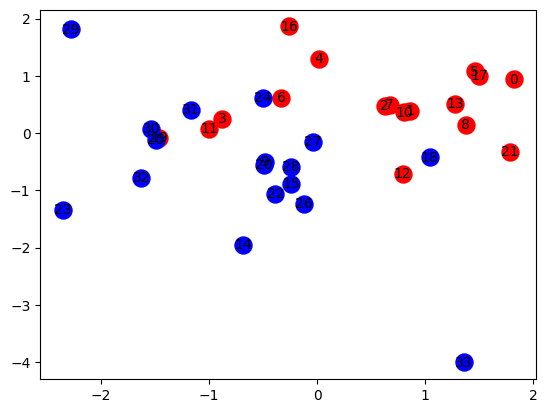

In [11]:
# plot the outputs on a 2D plane
plt.scatter(model.features()[:, 0].detach().numpy(), model.features()[:, 1].detach().numpy())

# if the ith node is labeled 0, color it red, else blue
for i in range(num_nodes):
    if labels[i] == 0:
        plt.scatter(model.features()[i, 0].detach().numpy(), model.features()[i, 1].detach().numpy(), color='red', s=150)
    else:
        plt.scatter(model.features()[i, 0].detach().numpy(), model.features()[i, 1].detach().numpy(), color='blue', s=150)

# label the nodes, centered
for i in range(num_nodes):
    plt.text(model.features()[i, 0].detach().numpy(), model.features()[i, 1].detach().numpy(), str(i), ha='center', va='center')

plt.show()

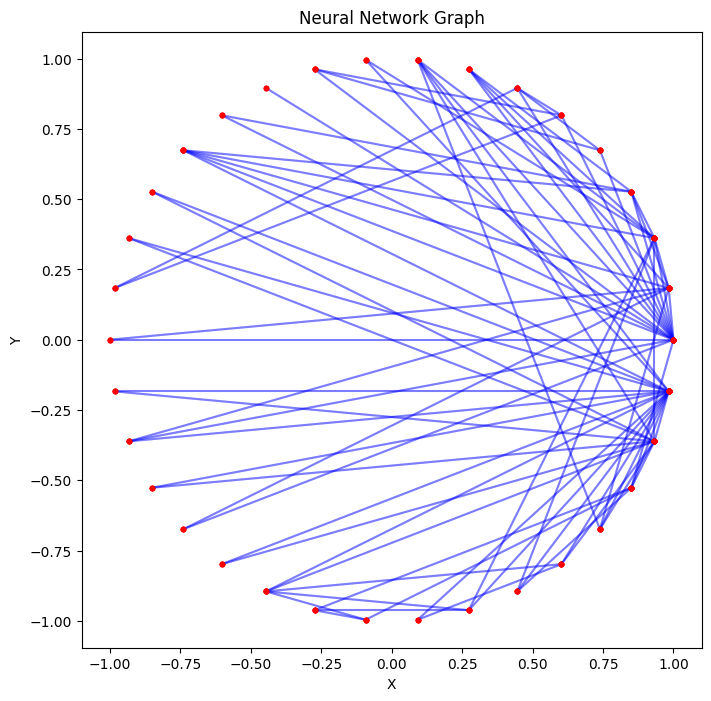

In [12]:
# calculate the positions of the neurons in a circular layout
radius = 1
angles = np.linspace(0, 2 * np.pi, num_nodes, endpoint=False)
x_positions = radius * np.cos(angles)
y_positions = radius * np.sin(angles)

# visualize the graph of neurons and their connections
plt.figure(figsize=(8, 8))

# adj = adj.numpy()
for i in range(num_nodes):
    for j in range(num_nodes):
        if adj[i][j] != 0:
            plt.plot([x_positions[i], x_positions[j]], [y_positions[i], y_positions[j]], 'b-', alpha=0.3)
            plt.plot(x_positions[i], y_positions[i], 'ro', markersize=3)
            plt.plot(x_positions[j], y_positions[j], 'ro', markersize=3)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network Graph')
plt.axis('equal')
plt.show()